In [1]:
%%bash

pip install -q kaggle
mkdir -p ~/.kaggle
cp drive/MyDrive/kaggle.json ~/.kaggle/
chmod 600 /root/.kaggle/kaggle.json
kaggle datasets download -d danielshanbalico/dog-vs-not-dog
unzip -qq dog-vs-not-dog.zip

100%|██████████| 2.86G/2.86G [00:23<00:00, 130MB/s]


In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pathlib
import PIL

In [29]:
data = pd.read_csv("Dog vs Not-Dog/labels.csv")
data.head()

,Unnamed: 0,filename,label
0,0,QYjQz1LS7dATFSYYRfnOfk6ezX8Gp49589.jpg,other
1,1,rltnrLmjyQgZnuSpbTKjPrm24wjHL43876.jpg,other
2,2,LNZNJPLSMhZAo8siLJlLVdHoxCTU5T11617.jpg,other
3,3,5ghe8eSnGWzfpowvy0oeLnqkEPqYbO8045.jpg,other
4,4,2V3zbjyoxmG3zKDyxTpN2GpEvVolj811765.jpg,dog


In [30]:
data.drop("Unnamed: 0", inplace=True, axis=1)

In [31]:
data_dir = pathlib.Path("Dog vs Not-Dog/")

In [32]:
image_count = len(list(data_dir.glob("*/*.jpg")))
image_count

24691

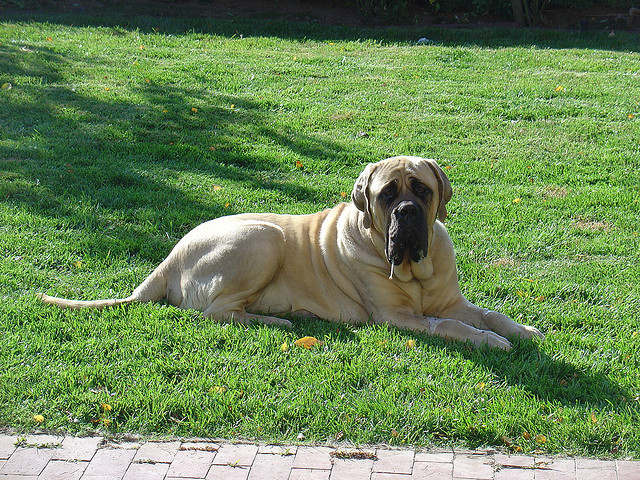

In [33]:
dog = list(data_dir.glob("dog/*"))
PIL.Image.open(str(dog[0]))

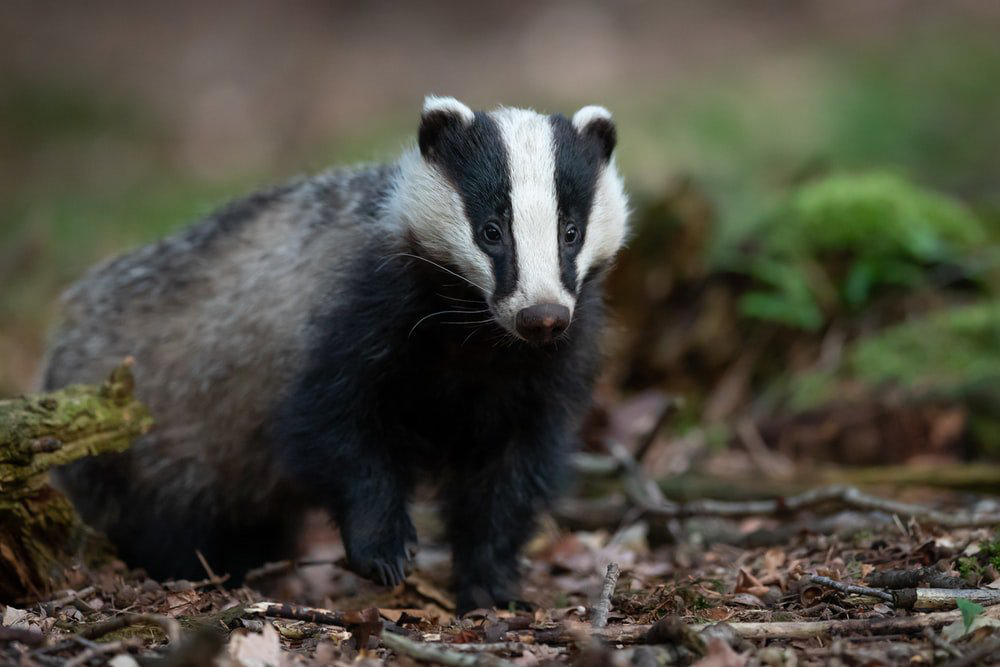

In [34]:
not_dog = list(data_dir.glob("other/*"))
PIL.Image.open(str(not_dog[0]))

In [35]:
img_height = 164
img_width = 164
batch_size = 32

In [36]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=437,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=437,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 25124 files belonging to 2 classes.
Using 20100 files for training.
Found 25124 files belonging to 2 classes.
Using 5024 files for validation.


In [37]:
class_names = train_ds.class_names
class_names

['dog', 'other']

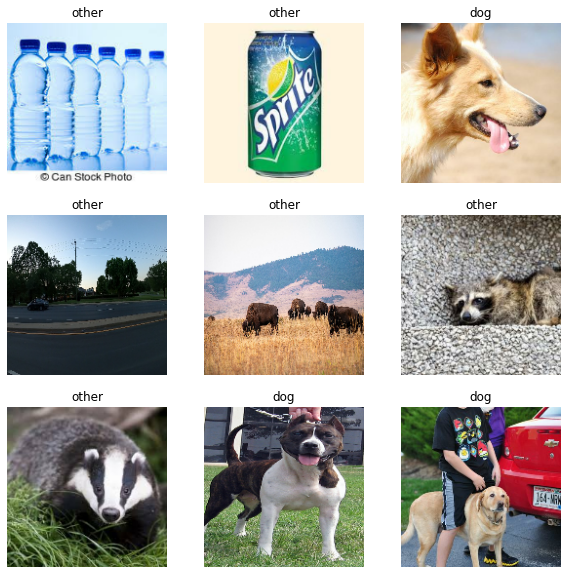

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [39]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 164, 164, 3)
(32,)


In [40]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [41]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
np.min(first_image), np.max(first_image)

(0.00031310666, 0.99946123)

In [42]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds= test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [43]:
base_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False, input_shape=(164, 164, 3))
base_model.trainable = False

In [44]:
inputs = tf.keras.layers.Input(shape=(164, 164, 3))
x = base_model(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [45]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 164, 164, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               6554112   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 21,269,313
Trainable params: 6,554,625
Non-tr

In [ ]:
model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=3
)

Epoch 1/3
  5/629 [..............................] - ETA: 1:50:28 - loss: 11.4600 - accuracy: 0.7937